In [1]:
%matplotlib inline

In [ ]:
import pandas as pd 

import duckdb
from tqdm.auto import tqdm 


In [7]:
histo_path = "/Users/raphaelcourivaud/Downloads/5000-signalement.csv"

df = pd.read_csv(histo_path)

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as mtick
from collections import Counter
import re


# 1. Data Completeness Analysis
def plot_completeness_heatmap(df, save_path=None):
    """
    Create a heatmap showing the completeness of each column
    This highlights missing data issues
    """
    plt.figure(figsize=(14, 10))
    
    # Calculate missing values for each column
    missing_data = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (missing_data / len(df) * 100).sort_values(ascending=False)
    
    # Create a DataFrame for the heatmap
    missing_df = pd.DataFrame({
        'Missing Count': missing_data,
        'Missing Percent': missing_percent
    })
    
    # Only include columns with missing values for better visualization
    missing_df = missing_df[missing_df['Missing Count'] > 0]
    
    if missing_df.empty:
        plt.text(0.5, 0.5, "No missing values found in the dataset!", 
                 fontsize=14, ha='center', va='center')
    else:
        # Sort by missing percentage
        missing_df = missing_df.sort_values('Missing Percent', ascending=False)
        
        # Create a readable heatmap (transpose for better visualization)
        missing_pivot = missing_df.transpose()
        
        # Plot heatmap
        sns.heatmap(missing_pivot, annot=True, cmap='YlOrRd', fmt='.1f', 
                    linewidths=.5, cbar_kws={'label': 'Value'})
        
        plt.title('Data Completeness Analysis: Missing Values (%)', fontsize=16, pad=20)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
        return f"Chart saved to {save_path}"
    else:
        plt.show()
        return "Chart displayed"

# 2. Column Data Type Analysis
def plot_data_types(df, save_path=None):
    """
    Create a bar chart showing the data types of each column
    Highlights potential data type issues
    """
    plt.figure(figsize=(12, 8))
    
    # Get data types for each column
    dtypes = df.dtypes.value_counts()
    
    # Plot
    ax = dtypes.plot(kind='bar', color=sns.color_palette("Set2"))
    
    # Add count labels
    for i, v in enumerate(dtypes):
        ax.text(i, v + 0.1, str(v), ha='center', fontweight='bold')
    
    plt.title('Column Data Types Distribution', fontsize=16)
    plt.xlabel('Data Type', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
        return f"Chart saved to {save_path}"
    else:
        plt.show()
        return "Chart displayed"

# 3. Value Distribution for Key Columns
def plot_value_distributions(df, columns, save_path=None):
    """
    Create histograms for key columns to show value distributions
    Helps identify outliers and data quality issues
    """
    n_cols = len(columns)
    if n_cols == 0:
        return "No columns provided"
    
    # Create a grid of subplots
    n_rows = (n_cols + 2) // 3  # Calculate rows needed (3 columns per row)
    fig, axes = plt.subplots(n_rows, min(n_cols, 3), figsize=(15, 4 * n_rows))
    
    # Flatten axes if multiple rows
    if n_rows > 1:
        axes = axes.flatten()
    elif n_cols == 1:  # Handle single plot case
        axes = [axes]
    
    for i, col in enumerate(columns):
        if i < len(axes):  # Ensure we don't exceed the number of subplots
            try:
                # Convert to numeric if possible
                series = pd.to_numeric(df[col], errors='coerce')
                
                # Plot histogram
                sns.histplot(series, ax=axes[i], kde=True)
                axes[i].set_title(f'Distribution of {col}', fontsize=10)
                axes[i].set_xlabel(col)
                
                # Add key statistics as text
                stats_text = (f"Mean: {series.mean():.2f}\n"
                            f"Median: {series.median():.2f}\n"
                            f"Min: {series.min():.2f}\n"
                            f"Max: {series.max():.2f}\n"
                            f"Missing: {series.isna().sum()} ({series.isna().mean()*100:.1f}%)")
                axes[i].text(0.95, 0.95, stats_text, transform=axes[i].transAxes,
                        fontsize=8, verticalalignment='top', horizontalalignment='right',
                        bbox={'boxstyle': 'round', 'facecolor': 'white', 'alpha': 0.8})
            except:
                # For non-numeric columns, show top values
                if df[col].dtype == 'object':
                    value_counts = df[col].value_counts().head(10)
                    value_counts.plot(kind='barh', ax=axes[i])
                    axes[i].set_title(f'Top 10 values: {col}', fontsize=10)
                    axes[i].set_xlabel('Count')
                    axes[i].set_ylabel(col)
                    
                    # Add missing values info
                    missing = df[col].isna().sum()
                    axes[i].text(0.95, 0.05, f"Missing: {missing} ({missing/len(df)*100:.1f}%)",
                            transform=axes[i].transAxes, fontsize=8,
                            verticalalignment='bottom', horizontalalignment='right',
                            bbox={'boxstyle': 'round', 'facecolor': 'white', 'alpha': 0.8})
                else:
                    axes[i].text(0.5, 0.5, f"Cannot visualize column: {col}",
                            ha='center', va='center', transform=axes[i].transAxes)
    
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.suptitle('Data Distributions for Key Columns', fontsize=16, y=1.02)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
        return f"Chart saved to {save_path}"
    else:
        plt.show()
        return "Chart displayed"

# 4. Consistency check for postal codes
def plot_postal_code_validity(df, save_path=None):
    """
    Analyze postal code validity
    Helps identify data consistency issues
    """
    plt.figure(figsize=(10, 8))
    
    if 'cp_occupant' not in df.columns:
        plt.text(0.5, 0.5, "No 'cp_occupant' column found in the dataset!",
                fontsize=14, ha='center', va='center')
    else:
        # Clean postal codes for analysis
        postal_codes = df['cp_occupant'].astype(str)
        
        # Define validity categories
        is_five_digits = postal_codes.str.match(r'^\d{5}$')
        starts_with_zero = postal_codes.str.match(r'^0\d{4}$')
        unusual_format = ~is_five_digits & ~postal_codes.isna()
        missing = postal_codes.isna()
        
        # Create data for pie chart
        labels = ['Valid 5-digit', 'Starts with 0', 'Unusual format', 'Missing']
        sizes = [
            is_five_digits.sum() - starts_with_zero.sum(),  # Valid non-zero
            starts_with_zero.sum(),  # Valid starting with 0
            unusual_format.sum(),  # Unusual format
            missing.sum()  # Missing
        ]
        
        # Plot
        plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90,
               colors=['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3'],
               wedgeprops={'edgecolor': 'w', 'linewidth': 1})
        
        plt.axis('equal')
        plt.title('Postal Code Data Quality Analysis', fontsize=16)
        
        # Add legend with counts
        legend_labels = [f"{label}: {count}" for label, count in zip(labels, sizes)]
        plt.legend(legend_labels, loc='upper right', bbox_to_anchor=(1.0, 0.9))
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
        return f"Chart saved to {save_path}"
    else:
        plt.show()
        return "Chart displayed"

# 5. Visualize inconsistent text formats
def plot_text_format_consistency(df, column, save_path=None):
    """
    Analyze text format consistency for a specific column
    Helps identify formatting issues
    """
    plt.figure(figsize=(10, 8))
    
    if column not in df.columns:
        plt.text(0.5, 0.5, f"No '{column}' column found in the dataset!",
                fontsize=14, ha='center', va='center')
    else:
        # Convert to string
        text_data = df[column].astype(str)
        
        # Define format categories (customize based on your data)
        is_title_case = text_data.str.istitle()
        is_upper_case = text_data.str.isupper()
        is_lower_case = text_data.str.islower()
        has_special_chars = text_data.str.contains(r'[^a-zA-Z0-9\s]')
        missing = text_data.isna() | (text_data == 'nan')
        other = ~(is_title_case | is_upper_case | is_lower_case | has_special_chars | missing)
        
        # Create data for pie chart
        labels = ['Title Case', 'ALL CAPS', 'lowercase', 'Has Special Chars', 'Missing/NaN', 'Other']
        sizes = [
            is_title_case.sum(),
            is_upper_case.sum(),
            is_lower_case.sum(),
            has_special_chars.sum(),
            missing.sum(),
            other.sum()
        ]
        
        # Filter out zero values
        non_zero_labels = [label for label, size in zip(labels, sizes) if size > 0]
        non_zero_sizes = [size for size in sizes if size > 0]
        
        # Plot
        plt.pie(non_zero_sizes, labels=non_zero_labels, autopct='%1.1f%%', startangle=90,
               colors=sns.color_palette("Set3", len(non_zero_labels)),
               wedgeprops={'edgecolor': 'w', 'linewidth': 1})
        
        plt.axis('equal')
        plt.title(f'Text Format Consistency: {column}', fontsize=16)
        
        # Add legend with counts
        legend_labels = [f"{label}: {count}" for label, count in zip(non_zero_labels, non_zero_sizes)]
        plt.legend(legend_labels, loc='upper right', bbox_to_anchor=(1.0, 0.9))
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
        return f"Chart saved to {save_path}"
    else:
        plt.show()
        return "Chart displayed"

# 6. Correlation matrix for numeric columns
def plot_correlation_matrix(df, save_path=None):
    """
    Create a correlation matrix for numeric columns
    Helps identify relationships and potential data issues
    """
    plt.figure(figsize=(12, 10))
    
    # Get numeric columns
    numeric_df = df.select_dtypes(include=[np.number])
    
    if numeric_df.empty or numeric_df.shape[1] < 2:
        plt.text(0.5, 0.5, "Not enough numeric columns for correlation analysis!",
                fontsize=14, ha='center', va='center')
    else:
        # Calculate correlation matrix
        corr = numeric_df.corr()
        
        # Generate a mask for the upper triangle
        mask = np.triu(np.ones_like(corr, dtype=bool))
        
        # Generate a custom diverging colormap
        cmap = sns.diverging_palette(230, 20, as_cmap=True)
        
        # Draw the heatmap
        sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
                    annot=True, fmt=".2f", square=True, linewidths=.5)
        
        plt.title('Correlation Matrix of Numeric Columns', fontsize=16)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
        return f"Chart saved to {save_path}"
    else:
        plt.show()
        return "Chart displayed"

# 7. Distribution of property types with missing values highlighted
def plot_property_types_with_missing(df, save_path=None):
    """
    Create a bar chart showing property types with missing fields highlighted
    """
    plt.figure(figsize=(14, 8))
    
    if 'nature_logement' not in df.columns:
        plt.text(0.5, 0.5, "No 'nature_logement' column found in the dataset!",
                fontsize=14, ha='center', va='center')
    else:
        # Get property types
        property_counts = df['nature_logement'].value_counts().sort_values(ascending=False).head(10)
        
        # Create a DataFrame for complete vs. missing information
        plot_data = []
        
        key_fields = ['superficie', 'nb_pieces_logement', 'etage_occupant']
        for prop_type in property_counts.index:
            subset = df[df['nature_logement'] == prop_type]
            
            # Count records with all key fields present
            complete = subset.dropna(subset=key_fields).shape[0]
            
            # Count records missing at least one key field
            missing = subset.shape[0] - complete
            
            plot_data.append({
                'property_type': prop_type,
                'complete': complete,
                'missing': missing
            })
        
        plot_df = pd.DataFrame(plot_data)
        
        # Set up the bar chart
        ax = plot_df.plot(x='property_type', y=['complete', 'missing'], 
                          kind='bar', stacked=True,
                          color=['#2ecc71', '#e74c3c'],
                          figsize=(14, 8))
        
        plt.title('Top 10 Property Types with Data Completeness', fontsize=16)
        plt.xlabel('Property Type', fontsize=12)
        plt.ylabel('Count', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.legend(['Complete Records', 'Missing Key Fields'], loc='upper right')
        
        # Add total count labels on top of bars
        for i, p in enumerate(property_counts.index):
            total = plot_df.loc[i, 'complete'] + plot_df.loc[i, 'missing']
            ax.text(i, total + 5, str(total), ha='center', fontweight='bold')
        
        plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
        return f"Chart saved to {save_path}"
    else:
        plt.show()
        return "Chart displayed"

# 8. Size vs. Rooms scatterplot with suspicious values highlighted
def plot_size_vs_rooms(df, save_path=None):
    """
    Create a scatter plot of size vs. rooms with suspicious values highlighted
    Helps identify inconsistent data
    """
    plt.figure(figsize=(12, 8))
    
    if 'superficie' not in df.columns or 'nb_pieces_logement' not in df.columns:
        plt.text(0.5, 0.5, "Missing required columns 'superficie' or 'nb_pieces_logement'!",
                fontsize=14, ha='center', va='center')
    else:
        # Convert to numeric
        superficie = pd.to_numeric(df['superficie'], errors='coerce')
        nb_pieces = pd.to_numeric(df['nb_pieces_logement'], errors='coerce')
        
        # Create a DataFrame for the scatter plot
        plot_df = pd.DataFrame({
            'superficie': superficie,
            'nb_pieces': nb_pieces
        }).dropna().query("superficie > 0 and nb_pieces > 0 and nb_pieces < 20 and superficie < 1000")
        
        if plot_df.empty:
            plt.text(0.5, 0.5, "No valid data points after conversion!",
                    fontsize=14, ha='center', va='center')
        else:
            # Identify suspicious values
            # Unreasonably small: <10 m² per room
            too_small = plot_df['superficie'] / plot_df['nb_pieces'] < 10
            
            # Unreasonably large: >100 m² per room
            too_large = plot_df['superficie'] / plot_df['nb_pieces'] > 100
            
            # Unrealistic rooms number (e.g., >10)
            many_rooms = plot_df['nb_pieces'] > 10
            
            # Normal data points
            normal = ~(too_small | too_large | many_rooms)
            
            # Plot normal points
            plt.scatter(plot_df.loc[normal, 'nb_pieces'], 
                        plot_df.loc[normal, 'superficie'],
                        alpha=0.5, color='#3498db', label='Normal')
            
            # Plot suspicious points
            plt.scatter(plot_df.loc[too_small, 'nb_pieces'], 
                        plot_df.loc[too_small, 'superficie'],
                        alpha=0.7, color='#e74c3c', label='Too small per room')
            
            plt.scatter(plot_df.loc[too_large, 'nb_pieces'], 
                        plot_df.loc[too_large, 'superficie'],
                        alpha=0.7, color='#f39c12', label='Too large per room')
            
            plt.scatter(plot_df.loc[many_rooms, 'nb_pieces'], 
                        plot_df.loc[many_rooms, 'superficie'],
                        alpha=0.7, color='#9b59b6', label='Unrealistic room count')
            
            # Add a trend line for normal data
            if normal.sum() > 1:  # Need at least 2 points for regression
                z = np.polyfit(plot_df.loc[normal, 'nb_pieces'], 
                               plot_df.loc[normal, 'superficie'], 1)
                p = np.poly1d(z)
                plt.plot(sorted(plot_df.loc[normal, 'nb_pieces'].unique()), 
                         p(sorted(plot_df.loc[normal, 'nb_pieces'].unique())), 
                         "k--", linewidth=1)
            
            plt.title('Property Size vs. Number of Rooms (Data Quality Check)', fontsize=16)
            plt.xlabel('Number of Rooms', fontsize=12)
            plt.ylabel('Size (m²)', fontsize=12)
            plt.legend()
            
            # Add suspicious data counts as text
            stats_text = (f"Normal data points: {normal.sum()}\n"
                        f"Too small per room: {too_small.sum()}\n"
                        f"Too large per room: {too_large.sum()}\n"
                        f"Unrealistic room count: {many_rooms.sum()}")
            
            plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes,
                    fontsize=10, verticalalignment='top',
                    bbox={'boxstyle': 'round', 'facecolor': 'white', 'alpha': 0.8})
            
            plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
        return f"Chart saved to {save_path}"
    else:
        plt.show()
        return "Chart displayed"

# 9. Unusual text values detection
def plot_unusual_text_values(df, column, save_path=None):
    """
    Analyze and visualize unusual text values in a column
    """
    plt.figure(figsize=(12, 8))
    
    if column not in df.columns:
        plt.text(0.5, 0.5, f"No '{column}' column found in the dataset!",
                fontsize=14, ha='center', va='center')
    else:
        # Convert to string
        text_data = df[column].astype(str)
        
        # Calculate text lengths
        text_lengths = text_data.str.len()
        
        # Define unusual categories
        very_short = text_lengths < 3
        very_long = text_lengths > 50
        has_numbers = text_data.str.contains(r'\d')
        has_special = text_data.str.contains(r'[^a-zA-Z0-9\s]')
        missing = text_data.isna() | (text_data == 'nan')
        normal = ~(very_short | very_long | has_numbers | has_special | missing)
        
        # Create data for bar chart
        categories = ['Normal', 'Very Short', 'Very Long', 'Has Numbers', 'Has Special Chars', 'Missing']
        counts = [normal.sum(), very_short.sum(), very_long.sum(), 
                  has_numbers.sum(), has_special.sum(), missing.sum()]
        
        # Plot
        plt.bar(categories, counts, color=sns.color_palette("Set3", len(categories)))
        
        # Add count labels
        for i, v in enumerate(counts):
            plt.text(i, v + 5, str(v), ha='center', fontweight='bold')
        
        plt.title(f'Unusual Text Value Detection: {column}', fontsize=16)
        plt.xlabel('Category', fontsize=12)
        plt.ylabel('Count', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Add some examples as text
        examples_text = "Examples of unusual values:\n"
        
        if very_short.sum() > 0:
            short_examples = df.loc[very_short, column].dropna().sample(min(3, very_short.sum())).tolist()
            examples_text += f"Very short: {', '.join([str(x) for x in short_examples])}\n\n"
        
        if very_long.sum() > 0:
            long_examples = df.loc[very_long, column].dropna().sample(min(2, very_long.sum())).tolist()
            examples_text += f"Very long: {', '.join([str(x)[:30] + '...' for x in long_examples])}\n\n"
        
        if has_numbers.sum() > 0:
            num_examples = df.loc[has_numbers, column].dropna().sample(min(3, has_numbers.sum())).tolist()
            examples_text += f"With numbers: {', '.join([str(x) for x in num_examples])}\n\n"
        
        if has_special.sum() > 0:
            special_examples = df.loc[has_special, column].dropna().sample(min(3, has_special.sum())).tolist()
            examples_text += f"With special chars: {', '.join([str(x) for x in special_examples])}"
        
        plt.figtext(0.5, 0.01, examples_text, ha='center', fontsize=9, 
                   bbox={'boxstyle': 'round', 'facecolor': 'white', 'alpha': 0.8})
    
    plt.tight_layout(rect=[0, 0.1, 1, 0.95])  # Make room for the examples text
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
        return f"Chart saved to {save_path}"
    else:
        plt.show()
        return "Chart displayed"
    

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as mtick
from collections import Counter
import re
import os
import matplotlib

# Set font preferences for better rendering
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['axes.titlesize'] = 14
matplotlib.rcParams['axes.labelsize'] = 12

# Load the dataset
def load_dataset(file_path):
    """Load the dataset without cleaning"""
    try:
        return pd.read_csv(file_path)
    except Exception as e:
        print(f"Error loading file: {e}")
        return None

# 1. Data Completeness Analysis - Split into Count and Percentage
def plot_completeness_analysis(df, save_path_count=None, save_path_percent=None):
    """
    Create two separate heatmaps showing the completeness of each column:
    1. Raw missing count
    2. Missing percentage
    """
    # Calculate missing values for each column
    missing_data = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (missing_data / len(df) * 100).sort_values(ascending=False)
    
    # Filter columns with missing values for better visualization
    missing_data = missing_data[missing_data > 0]
    missing_percent = missing_percent[missing_percent > 0]
    
    if missing_data.empty:
        # Create a simple figure stating no missing values
        plt.figure(figsize=(10, 6))
        plt.text(0.5, 0.5, "No missing values found in the dataset!", 
                 fontsize=14, ha='center', va='center')
        plt.axis('off')
        
        if save_path_count:
            plt.savefig(save_path_count, dpi=300, bbox_inches='tight')
        if save_path_percent:
            plt.savefig(save_path_percent, dpi=300, bbox_inches='tight')
        
        plt.close()
        return "No missing values found"
    
    # 1. Plot Missing Count
    plt.figure(figsize=(12, 10))
    missing_data_df = pd.DataFrame({'Missing Count': missing_data})
    missing_data_df = missing_data_df.sort_values('Missing Count', ascending=True)
    
    ax = sns.barplot(x=missing_data_df['Missing Count'], y=missing_data_df.index, 
                    palette='YlOrRd_r')
    
    # Add count labels
    for i, v in enumerate(missing_data_df['Missing Count']):
        ax.text(v + 5, i, str(v), va='center')
    
    plt.title('Missing Value Counts by Column', fontsize=16)
    plt.xlabel('Count of Missing Values', fontsize=12)
    plt.ylabel('Column', fontsize=12)
    plt.tight_layout()
    
    if save_path_count:
        plt.savefig(save_path_count, dpi=300, bbox_inches='tight')
        plt.close()
    else:
        plt.show()
    
    # 2. Plot Missing Percentage
    plt.figure(figsize=(12, 10))
    missing_percent_df = pd.DataFrame({'Missing Percent': missing_percent})
    missing_percent_df = missing_percent_df.sort_values('Missing Percent', ascending=True)
    
    ax = sns.barplot(x=missing_percent_df['Missing Percent'], y=missing_percent_df.index, 
                    palette='YlOrRd_r')
    
    # Add percentage labels
    for i, v in enumerate(missing_percent_df['Missing Percent']):
        ax.text(v + 0.5, i, f"{v:.1f}%", va='center')
    
    plt.title('Missing Value Percentage by Column', fontsize=16)
    plt.xlabel('Percentage of Missing Values', fontsize=12)
    plt.ylabel('Column', fontsize=12)
    plt.tight_layout()
    
    if save_path_percent:
        plt.savefig(save_path_percent, dpi=300, bbox_inches='tight')
        plt.close()
        return f"Charts saved to {save_path_count} and {save_path_percent}"
    else:
        plt.show()
        return "Charts displayed"

# 2. Improved Value Distribution for numeric columns with outlier analysis
def plot_improved_distribution(df, column, save_path=None):
    """
    Create an improved distribution visualization for a numeric column
    with separate analysis of outliers
    """
    if column not in df.columns:
        print(f"Column '{column}' not found in dataframe")
        return None
    
    # Convert to numeric
    series = pd.to_numeric(df[column], errors='coerce')
    
    # Skip if no valid numeric data
    if series.isna().all():
        print(f"No valid numeric data in column '{column}'")
        return None
    
    # Create figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), gridspec_kw={'height_ratios': [2, 1]})
    
    # 1. Main distribution (excluding extreme outliers)
    # Calculate IQR and bounds
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter out extreme outliers for the main plot
    main_data = series[(series >= lower_bound) & (series <= upper_bound)]
    
    # Create the main histogram
    sns.histplot(main_data, kde=True, ax=ax1, color='#3498db')
    ax1.set_title(f'Distribution of {column} (Excluding Extreme Outliers)', fontsize=14)
    ax1.set_xlabel(f'{column} (filtered range: {lower_bound:.2f} to {upper_bound:.2f})', fontsize=12)
    ax1.set_ylabel('Count', fontsize=12)
    
    # Add vertical lines for quartiles and median
    ax1.axvline(Q1, color='r', linestyle='--', alpha=0.6, label=f'Q1: {Q1:.2f}')
    ax1.axvline(series.median(), color='g', linestyle='-', alpha=0.6, label=f'Median: {series.median():.2f}')
    ax1.axvline(Q3, color='b', linestyle='--', alpha=0.6, label=f'Q3: {Q3:.2f}')
    ax1.legend()
    
    # Add key statistics
    stats_text = (f"Mean: {series.mean():.2f}\n"
                 f"Median: {series.median():.2f}\n"
                 f"Std Dev: {series.std():.2f}\n"
                 f"Min (non-outlier): {main_data.min():.2f}\n"
                 f"Max (non-outlier): {main_data.max():.2f}")
    
    ax1.text(0.95, 0.95, stats_text, transform=ax1.transAxes,
            fontsize=10, verticalalignment='top', horizontalalignment='right',
            bbox={'boxstyle': 'round', 'facecolor': 'white', 'alpha': 0.8})
    
    # 2. Outlier analysis
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    
    if outliers.empty:
        ax2.text(0.5, 0.5, "No outliers detected!", 
                fontsize=14, ha='center', va='center')
        ax2.axis('off')
    else:
        # Create bins for the outliers
        if len(outliers) > 1:
            # Determine appropriate number of bins for outliers
            bin_count = min(20, len(outliers.unique()))
            
            sns.histplot(outliers, bins=bin_count, ax=ax2, color='#e74c3c')
            ax2.set_title(f'Distribution of Outliers in {column}', fontsize=14)
            ax2.set_xlabel(column, fontsize=12)
            ax2.set_ylabel('Count', fontsize=12)
        else:
            # Just a bar chart if only one unique outlier value
            ax2.bar(outliers.iloc[0], len(outliers), color='#e74c3c')
            ax2.set_title(f'Single Outlier Value in {column}', fontsize=14)
            ax2.set_xlabel(column, fontsize=12)
            ax2.set_ylabel('Count', fontsize=12)
        
        # Add outlier statistics
        outlier_stats = (f"Number of outliers: {len(outliers)} ({len(outliers)/len(series)*100:.2f}% of data)\n"
                        f"Min outlier: {outliers.min():.2f}\n"
                        f"Max outlier: {outliers.max():.2f}")
        
        ax2.text(0.95, 0.95, outlier_stats, transform=ax2.transAxes,
                fontsize=10, verticalalignment='top', horizontalalignment='right',
                bbox={'boxstyle': 'round', 'facecolor': 'white', 'alpha': 0.8})
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
        return f"Chart saved to {save_path}"
    else:
        plt.show()
        return "Chart displayed"

# 3. Improved Size vs. Rooms scatterplot with better outlier handling
def plot_improved_size_vs_rooms(df, save_path=None):
    """
    Create an improved scatter plot of size vs. rooms with better outlier analysis
    """
    if 'superficie' not in df.columns or 'nb_pieces_logement' not in df.columns:
        print("Missing required columns 'superficie' or 'nb_pieces_logement'")
        return None
    
    # Convert to numeric
    superficie = pd.to_numeric(df['superficie'], errors='coerce')
    nb_pieces = pd.to_numeric(df['nb_pieces_logement'], errors='coerce')
    
    # Create a DataFrame for the scatter plot
    plot_df = pd.DataFrame({
        'superficie': superficie,
        'nb_pieces': nb_pieces
    }).dropna()
    
    if plot_df.empty:
        print("No valid data points after conversion")
        return None
    
    # Create figure with 2 subplots (main scatter and zoomed-in view)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    
    # Calculate reasonable bounds
    superficie_q1 = plot_df['superficie'].quantile(0.25)
    superficie_q3 = plot_df['superficie'].quantile(0.75)
    superficie_iqr = superficie_q3 - superficie_q1
    superficie_upper = superficie_q3 + 1.5 * superficie_iqr
    
    nb_pieces_q1 = plot_df['nb_pieces'].quantile(0.25)
    nb_pieces_q3 = plot_df['nb_pieces'].quantile(0.75)
    nb_pieces_iqr = nb_pieces_q3 - nb_pieces_q1
    nb_pieces_upper = nb_pieces_q3 + 1.5 * nb_pieces_iqr
    
    # 1. Full Scatter plot with all data
    scatter1 = ax1.scatter(plot_df['nb_pieces'], plot_df['superficie'], 
                       alpha=0.6, c=plot_df['superficie']/plot_df['nb_pieces'], 
                       cmap='viridis', s=30)
    
    ax1.set_title('Property Size vs. Number of Rooms (All Data)', fontsize=14)
    ax1.set_xlabel('Number of Rooms', fontsize=12)
    ax1.set_ylabel('Size (m²)', fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # Add colorbar to show m² per room
    cbar = plt.colorbar(scatter1, ax=ax1)
    cbar.set_label('m² per room')
    
    # Add stat zones
    ax1.axhline(y=superficie_upper, color='red', linestyle='--', alpha=0.5, 
              label=f'Size Outlier Threshold: {superficie_upper:.0f} m²')
    ax1.axvline(x=nb_pieces_upper, color='orange', linestyle='--', alpha=0.5,
              label=f'Room Count Outlier Threshold: {nb_pieces_upper:.0f}')
    
    # Mark extreme outliers
    extreme_size = plot_df[plot_df['superficie'] > superficie_upper]
    extreme_rooms = plot_df[plot_df['nb_pieces'] > nb_pieces_upper]
    
    ax1.scatter(extreme_size['nb_pieces'], extreme_size['superficie'], 
               color='red', s=50, alpha=0.7, edgecolors='black', label='Size Outliers')
    ax1.scatter(extreme_rooms['nb_pieces'], extreme_rooms['superficie'], 
               color='orange', s=50, alpha=0.7, edgecolors='black', label='Room Count Outliers')
    
    # Add outlier statistics
    outlier_stats = (f"Size outliers: {len(extreme_size)} ({len(extreme_size)/len(plot_df)*100:.1f}%)\n"
                   f"Room outliers: {len(extreme_rooms)} ({len(extreme_rooms)/len(plot_df)*100:.1f}%)")
    
    ax1.text(0.02, 0.98, outlier_stats, transform=ax1.transAxes,
            fontsize=10, verticalalignment='top',
            bbox={'boxstyle': 'round', 'facecolor': 'white', 'alpha': 0.8})
    
    ax1.legend(loc='upper left')
    
    # 2. Zoomed-in view with normal data
    normal_data = plot_df[(plot_df['superficie'] <= superficie_upper) & 
                           (plot_df['nb_pieces'] <= nb_pieces_upper)]
    
    scatter2 = ax2.scatter(normal_data['nb_pieces'], normal_data['superficie'], 
                       alpha=0.6, c=normal_data['superficie']/normal_data['nb_pieces'], 
                       cmap='viridis', s=30)
    
    ax2.set_title('Property Size vs. Number of Rooms (Normal Range Only)', fontsize=14)
    ax2.set_xlabel('Number of Rooms', fontsize=12)
    ax2.set_ylabel('Size (m²)', fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    # Add trend line
    if len(normal_data) > 1:
        z = np.polyfit(normal_data['nb_pieces'], normal_data['superficie'], 1)
        p = np.poly1d(z)
        ax2.plot(sorted(normal_data['nb_pieces'].unique()), 
               p(sorted(normal_data['nb_pieces'].unique())), 
               "k--", linewidth=2, label=f'Trend: y = {z[0]:.1f}x + {z[1]:.1f}')
    
    # Add reference lines for average size per room
    for m2_per_room in [10, 20, 30, 40]:
        x = np.linspace(0, normal_data['nb_pieces'].max() * 1.1, 100)
        y = m2_per_room * x
        ax2.plot(x, y, '--', alpha=0.3, color='gray', 
               label=f'{m2_per_room} m² per room' if m2_per_room == 20 else "")
    
    # Add text annotation for reference lines
    ax2.text(normal_data['nb_pieces'].max() * 0.95, 
            normal_data['nb_pieces'].max() * 10 * 0.95, 
            '10 m²/room', fontsize=8, ha='right', color='gray')
    
    ax2.text(normal_data['nb_pieces'].max() * 0.95, 
            normal_data['nb_pieces'].max() * 20 * 0.95, 
            '20 m²/room', fontsize=8, ha='right', color='gray')
    
    ax2.text(normal_data['nb_pieces'].max() * 0.95, 
            normal_data['nb_pieces'].max() * 30 * 0.95, 
            '30 m²/room', fontsize=8, ha='right', color='gray')
    
    ax2.text(normal_data['nb_pieces'].max() * 0.95, 
            normal_data['nb_pieces'].max() * 40 * 0.95, 
            '40 m²/room', fontsize=8, ha='right', color='gray')
    
    # Add normal stats box
    normal_stats = (f"Normal data points: {len(normal_data)}\n"
                  f"Avg size: {normal_data['superficie'].mean():.1f} m²\n"
                  f"Avg rooms: {normal_data['nb_pieces'].mean():.1f}\n"
                  f"Avg m² per room: {(normal_data['superficie']/normal_data['nb_pieces']).mean():.1f}")
    
    ax2.text(0.02, 0.98, normal_stats, transform=ax2.transAxes,
            fontsize=10, verticalalignment='top',
            bbox={'boxstyle': 'round', 'facecolor': 'white', 'alpha': 0.8})
    
    ax2.legend(loc='upper left')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
        return f"Chart saved to {save_path}"
    else:
        plt.show()
        return "Chart displayed"

# 4. Floor data analysis
def plot_floor_analysis(df, save_path=None):
    """
    Analyze the 'etage_occupant' field to show inconsistencies in floor data
    """
    if 'etage_occupant' not in df.columns:
        print("Column 'etage_occupant' not found in dataframe")
        return None
    
    plt.figure(figsize=(16, 12))
    
    # Create a grid with 2 subplots
    gs = plt.GridSpec(2, 1, height_ratios=[1, 2])
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    
    # Get non-null floor values
    floor_data = df['etage_occupant'].dropna()
    
    if floor_data.empty:
        plt.text(0.5, 0.5, "No floor data available ('etage_occupant' is all null)",
                fontsize=14, ha='center', va='center')
    else:
        # 1. Top 20 most common floor values
        top_values = floor_data.value_counts().head(20)
        
        ax1.bar(range(len(top_values)), top_values, color=sns.color_palette("viridis", len(top_values)))
        ax1.set_xticks(range(len(top_values)))
        ax1.set_xticklabels(top_values.index, rotation=45, ha='right')
        ax1.set_title('Top 20 Most Common Floor Values', fontsize=14)
        ax1.set_ylabel('Count', fontsize=12)
        
        # Add count labels
        for i, v in enumerate(top_values):
            ax1.text(i, v + 2, str(v), ha='center', fontsize=9)
        
        # 2. Categorize floor values to show inconsistency
        floor_data_str = floor_data.astype(str).str.lower()
        
        # Define patterns to identify
        patterns = {
            "Ground floor (RDC)": floor_data_str.str.contains('rdc|rez|r\+0|rdch|r dc|rch|rez de chaussée', regex=True),
            "1st floor (explicit)": floor_data_str.str.contains('1er|1eme|1ère|1e et|1e|premier|^1$|^1 |1er et|^1\s*$', regex=True),
            "2nd floor (explicit)": floor_data_str.str.contains('2eme|2ème|2e et|2e|deuxieme|^2$|^2 |2nd|2d|2e et|^2\s*$', regex=True),
            "3rd floor (explicit)": floor_data_str.str.contains('3eme|3ème|3e et|3e|troisieme|^3$|^3 |3e et|^3\s*$', regex=True),
            "4th floor (explicit)": floor_data_str.str.contains('4eme|4ème|4e et|4e|quatrieme|^4$|^4 |4e et|^4\s*$', regex=True),
            "5th+ floor (explicit)": floor_data_str.str.contains('5eme|5ème|5e|6eme|6e|7eme|8|9|10', regex=True),
            "R+N format": floor_data_str.str.contains('r\+[1-9]', regex=True),
            "Contains numbers only": floor_data_str.str.match(r'^\d+$'),
            "Contains numbers & text": floor_data_str.str.contains(r'\d') & ~floor_data_str.str.match(r'^\d+$'),
            "Special format": floor_data_str.str.contains('-', regex=True),
            "Other format": ~floor_data_str.str.contains('rdc|rez|r\+|1er|2eme|3eme|4eme|5|6|7|8|9|10|\d|-', regex=True)
        }
        
        # Count each pattern
        pattern_counts = {name: sum(mask) for name, mask in patterns.items()}
        
        # Convert to DataFrame for plotting
        pattern_df = pd.DataFrame({
            'Category': list(pattern_counts.keys()),
            'Count': list(pattern_counts.values())
        }).sort_values('Count', ascending=False)
        
        # Plot pattern distribution
        ax2.bar(range(len(pattern_df)), pattern_df['Count'], 
              color=sns.color_palette("plasma", len(pattern_df)))
        ax2.set_xticks(range(len(pattern_df)))
        ax2.set_xticklabels(pattern_df['Category'], rotation=45, ha='right')
        ax2.set_title('Floor Value Format Categories (Showing Inconsistency)', fontsize=14)
        ax2.set_ylabel('Count', fontsize=12)
        
        # Add count and percentage labels
        total = sum(pattern_counts.values())
        for i, v in enumerate(pattern_df['Count']):
            percentage = (v / total) * 100
            ax2.text(i, v + 5, f"{v}\n({percentage:.1f}%)", ha='center', fontsize=9)
        
        # Add examples as text boxes
        examples_text = "Examples of inconsistent floor formats:\n"
        for category, mask in patterns.items():
            if sum(mask) > 0:
                examples = floor_data[mask].sample(min(3, sum(mask))).tolist()
                examples_str = ", ".join([f"'{str(ex)}'" for ex in examples])
                examples_text += f"{category}: {examples_str}\n"
        
        fig = plt.gcf()
        fig.text(0.5, 0.01, examples_text, ha='center', fontsize=10,
               bbox={'boxstyle': 'round', 'facecolor': 'white', 'alpha': 0.8})
    
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
        return f"Chart saved to {save_path}"
    else:
        plt.show()
        return "Chart displayed"

# 5. Staircase/apartment number analysis 
def plot_apartment_staircase_analysis(df, save_path=None):
    """
    Analyze escalier_occupant and num_appart_occupant fields to show inconsistencies
    """
    if 'escalier_occupant' not in df.columns or 'num_appart_occupant' not in df.columns:
        print("Required columns not found in dataframe")
        return None
    
    # Create figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))
    
    # 1. Staircase data analysis (escalier_occupant)
    staircase_data = df['escalier_occupant'].dropna()
    
    if staircase_data.empty:
        ax1.text(0.5, 0.5, "No staircase data available (all null)",
                fontsize=14, ha='center', va='center')
        ax1.axis('off')
    else:
        staircase_data_str = staircase_data.astype(str).str.lower()
        
        # Define patterns for staircase
        stair_patterns = {
            "Single letter": staircase_data_str.str.match(r'^[a-z]$'),
            "Single digit": staircase_data_str.str.match(r'^\d$'),
            "Multiple digits": staircase_data_str.str.match(r'^\d{2,}$'),
            "Letter + Number": staircase_data_str.str.contains(r'[a-z].*\d|\d.*[a-z]', regex=True),
            "Contains 'esc'/'escalier'": staircase_data_str.str.contains('esc|escalier'),
            "Special characters": staircase_data_str.str.contains(r'[^a-z0-9\s]'),
            "Other format": ~staircase_data_str.str.match(r'^[a-z]$|^\d+$') & 
                           ~staircase_data_str.str.contains(r'[a-z].*\d|\d.*[a-z]|esc|escalier|[^a-z0-9\s]', regex=True)
        }
        
        # Count each pattern
        stair_counts = {name: sum(mask) for name, mask in stair_patterns.items()}
        
        # Convert to DataFrame for plotting
        stair_df = pd.DataFrame({
            'Category': list(stair_counts.keys()),
            'Count': list(stair_counts.values())
        }).sort_values('Count', ascending=False)
        
        # Plot pattern distribution
        bars = ax1.bar(range(len(stair_df)), stair_df['Count'], 
                    color=sns.color_palette("Blues_r", len(stair_df)))
        ax1.set_xticks(range(len(stair_df)))
        ax1.set_xticklabels(stair_df['Category'], rotation=45, ha='right')
        ax1.set_title('Staircase Value Format Categories (escalier_occupant)', fontsize=14)
        ax1.set_ylabel('Count', fontsize=12)
        
        # Add count and percentage labels
        total_stair = sum(stair_counts.values())
        for i, v in enumerate(stair_df['Count']):
            percentage = (v / total_stair) * 100
            ax1.text(i, v + 2, f"{v}\n({percentage:.1f}%)", ha='center', fontsize=9)
        
        # Add examples for staircase
        examples_text = "Examples of staircase formats:\n"
        for category, mask in stair_patterns.items():
            if sum(mask) > 0:
                examples = staircase_data[mask].sample(min(2, sum(mask))).tolist()
                examples_str = ", ".join([f"'{str(ex)}'" for ex in examples])
                examples_text += f"{category}: {examples_str}\n"
        
        ax1.text(0.02, 0.97, examples_text, transform=ax1.transAxes,
                fontsize=9, verticalalignment='top',
                bbox={'boxstyle': 'round', 'facecolor': 'white', 'alpha': 0.8})
    
    # 2. Apartment number analysis (num_appart_occupant)
    apt_data = df['num_appart_occupant'].dropna()
    
    if apt_data.empty:
        ax2.text(0.5, 0.5, "No apartment number data available (all null)",
                fontsize=14, ha='center', va='center')
        ax2.axis('off')
    else:
        apt_data_str = apt_data.astype(str).str.lower()
        
        # Define patterns for apartment numbers
        apt_patterns = {
            "Single digit": apt_data_str.str.match(r'^\d$'),
            "2-3 digits": apt_data_str.str.match(r'^\d{2,3}$'),
            "4+ digits": apt_data_str.str.match(r'^\d{4,}$'),
            "Contains letter(s)": apt_data_str.str.contains(r'[a-z]'),
            "Likely floor+door": apt_data_str.str.match(r'^\d{3}$') & apt_data_str.str.match(r'^[1-9]'),
            "Contains 'appt'/'app'": apt_data_str.str.contains('app|appt|apt'),
            "Contains 'porte'": apt_data_str.str.contains('porte'),
            "Special characters": apt_data_str.str.contains(r'[^a-z0-9\s]'),
            "Other format": ~apt_data_str.str.match(r'^\d+$') & 
                            ~apt_data_str.str.contains(r'[a-z]|app|appt|apt|porte|[^a-z0-9\s]', regex=True)
        }
        
        # Count each pattern
        apt_counts = {name: sum(mask) for name, mask in apt_patterns.items()}
        
        # Convert to DataFrame for plotting
        apt_df = pd.DataFrame({
            'Category': list(apt_counts.keys()),
            'Count': list(apt_counts.values())
        }).sort_values('Count', ascending=False)
        
        # Plot pattern distribution
        bars = ax2.bar(range(len(apt_df)), apt_df['Count'],
                      color=sns.color_palette("Oranges_r", len(apt_df)))
        ax2.set_xticks(range(len(apt_df)))
        ax2.set_xticklabels(apt_df['Category'], rotation=45, ha='right')
        ax2.set_title('Apartment Number Format Categories (num_appart_occupant)', fontsize=14)
        ax2.set_ylabel('Count', fontsize=12)
        
        # Add count and percentage labels
        total_apt = sum(apt_counts.values())
        for i, v in enumerate(apt_df['Count']):
            percentage = (v / total_apt) * 100
            ax2.text(i, v + 2, f"{v}\n({percentage:.1f}%)", ha='center', fontsize=9)
        
        # Add examples for apartment numbers
        examples_text = "Examples of apartment number formats:\n"
        for category, mask in apt_patterns.items():
            if sum(mask) > 0:
                examples = apt_data[mask].sample(min(2, sum(mask))).tolist()
                examples_str = ", ".join([f"'{str(ex)}'" for ex in examples])
                examples_text += f"{category}: {examples_str}\n"
        
        ax2.text(0.02, 0.97, examples_text, transform=ax2.transAxes,
                fontsize=9, verticalalignment='top',
                bbox={'boxstyle': 'round', 'facecolor': 'white', 'alpha': 0.8})
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
        return f"Chart saved to {save_path}"
    else:
        plt.show()
        return "Chart displayed"

# Main function to create all visualizations
def create_data_quality_visualizations(df, output_dir='.'):
    """
    Create all data quality visualizations
    
    Parameters:
    df (pandas.DataFrame): The dataset to analyze
    output_dir (str): Directory to save visualizations
    
    Returns:
    dict: Paths to all generated visualizations
    """
    import os
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Dictionary to store visualization paths
    viz_paths = {}
    
    # 1. Data Completeness Heatmap
    viz_paths['completeness'] = os.path.join(output_dir, '1_data_completeness.png')
    plot_completeness_heatmap(df, viz_paths['completeness'])
    
    # 2. Column Data Types
    viz_paths['data_types'] = os.path.join(output_dir, '2_column_data_types.png')
    plot_data_types(df, viz_paths['data_types'])
    
    # 3. Value Distributions for Key Columns
    key_columns = ['superficie', 'nb_pieces_logement', 'annee_construction']
    viz_paths['distributions'] = os.path.join(output_dir, '3_key_distributions.png')
    plot_value_distributions(df, key_columns, viz_paths['distributions'])
    
    # 4. Postal Code Validity
    viz_paths['postal_codes'] = os.path.join(output_dir, '4_postal_code_validity.png')
    plot_postal_code_validity(df, viz_paths['postal_codes'])
    
    # 5. Text Format Consistency for ville_occupant
    viz_paths['text_format'] = os.path.join(output_dir, '5_text_format_consistency.png')
    plot_text_format_consistency(df, 'ville_occupant', viz_paths['text_format'])
    
    # 6. Correlation Matrix
    viz_paths['correlation'] = os.path.join(output_dir, '6_correlation_matrix.png')
    plot_correlation_matrix(df, viz_paths['correlation'])
    
    # 7. Property Types with Missing Values
    viz_paths['property_types'] = os.path.join(output_dir, '7_property_types_completeness.png')
    plot_property_types_with_missing(df, viz_paths['property_types'])
    
    # 8. Size vs. Rooms with Suspicious Values
    viz_paths['size_vs_rooms'] = os.path.join(output_dir, '8_size_vs_rooms.png')
    plot_size_vs_rooms(df, viz_paths['size_vs_rooms'])
    
    # 9. Unusual Text Values in Address
    viz_paths['unusual_text'] = os.path.join(output_dir, '9_unusual_text_values.png')
    plot_unusual_text_values(df, 'adresse_occupant', viz_paths['unusual_text'])

    plot_completeness_analysis(df, save_path_count="completeness_count.png", save_path_percent="completeness_percent.png")
    plot_improved_size_vs_rooms(df, save_path="size_vs_rooms.png")
    plot_floor_analysis(df, save_path="floor_analysis.png")
    plot_apartment_staircase_analysis(df, save_path="apartment_staircase_analysis.png")
    
    return viz_paths

    


In [18]:
plot_size_vs_rooms(df, "data_quality_viz/size_vs_rooms.png")


'Chart saved to data_quality_viz/size_vs_rooms.png'

In [14]:
viz_paths = create_data_quality_visualizations(df, output_dir='data_quality_viz')

for name, path in viz_paths.items():
    print(f"- {name}: {path}")

/Users/raphaelcourivaud/anaconda3/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/raphaelcourivaud/anaconda3/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/raphaelcourivaud/anaconda3/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/_v/10w6h3595jb25htv66pv5fq80000gn/T/ipykernel_96554/3300046314.py:538: UserWarning: Glyph 65533 

- completeness: data_quality_viz/1_data_completeness.png
- data_types: data_quality_viz/2_column_data_types.png
- distributions: data_quality_viz/3_key_distributions.png
- postal_codes: data_quality_viz/4_postal_code_validity.png
- text_format: data_quality_viz/5_text_format_consistency.png
- correlation: data_quality_viz/6_correlation_matrix.png
- property_types: data_quality_viz/7_property_types_completeness.png
- size_vs_rooms: data_quality_viz/8_size_vs_rooms.png
- unusual_text: data_quality_viz/9_unusual_text_values.png


<Figure size 1400x800 with 0 Axes>

/var/folders/_v/10w6h3595jb25htv66pv5fq80000gn/T/ipykernel_96554/2839848338.py:238: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/var/folders/_v/10w6h3595jb25htv66pv5fq80000gn/T/ipykernel_96554/2839848338.py:242: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  plt.savefig(output_path, dpi=300, bbox_inches='tight')


Summary visualizations created at: {'numeric_summary': 'data_summary/numeric_summary.png', 'categorical_summary': 'data_summary/categorical_summary.png'}


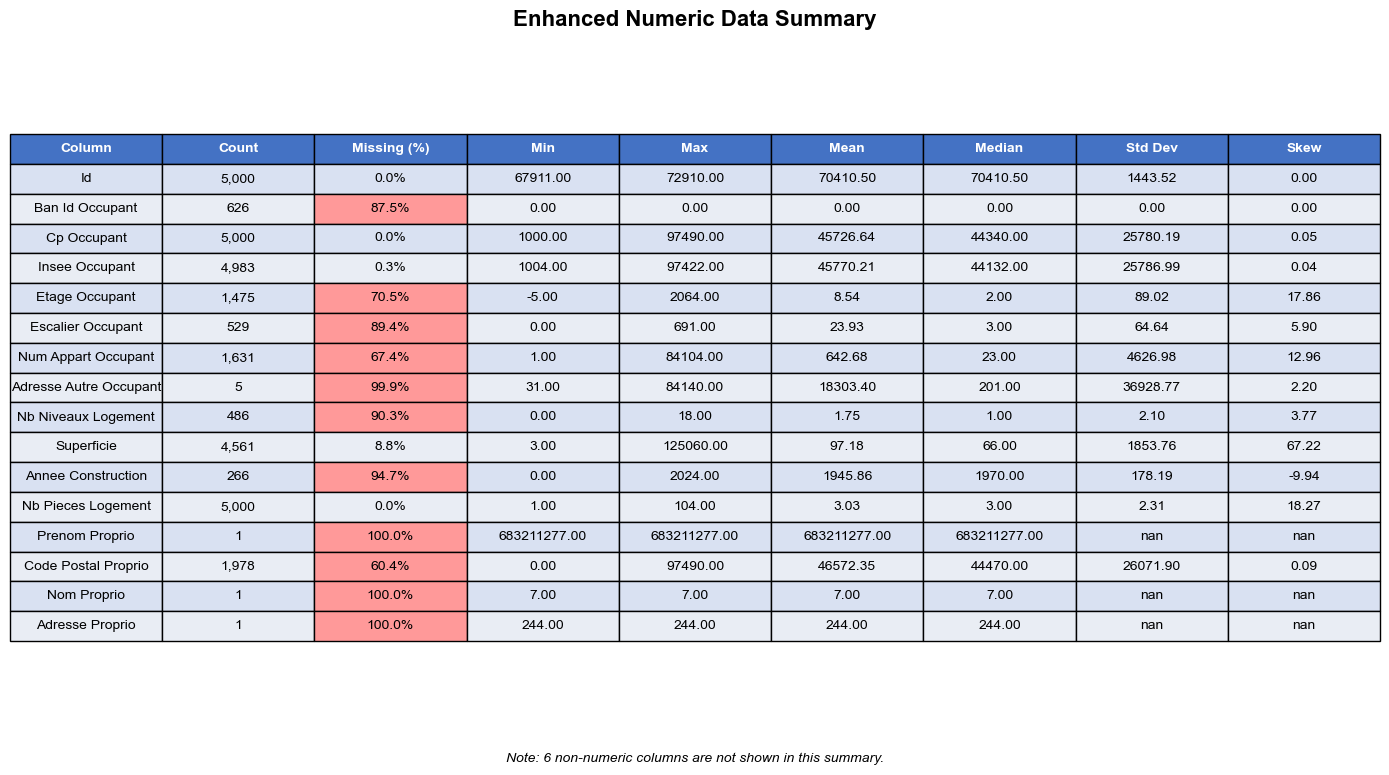

/Users/raphaelcourivaud/anaconda3/envs/py310/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


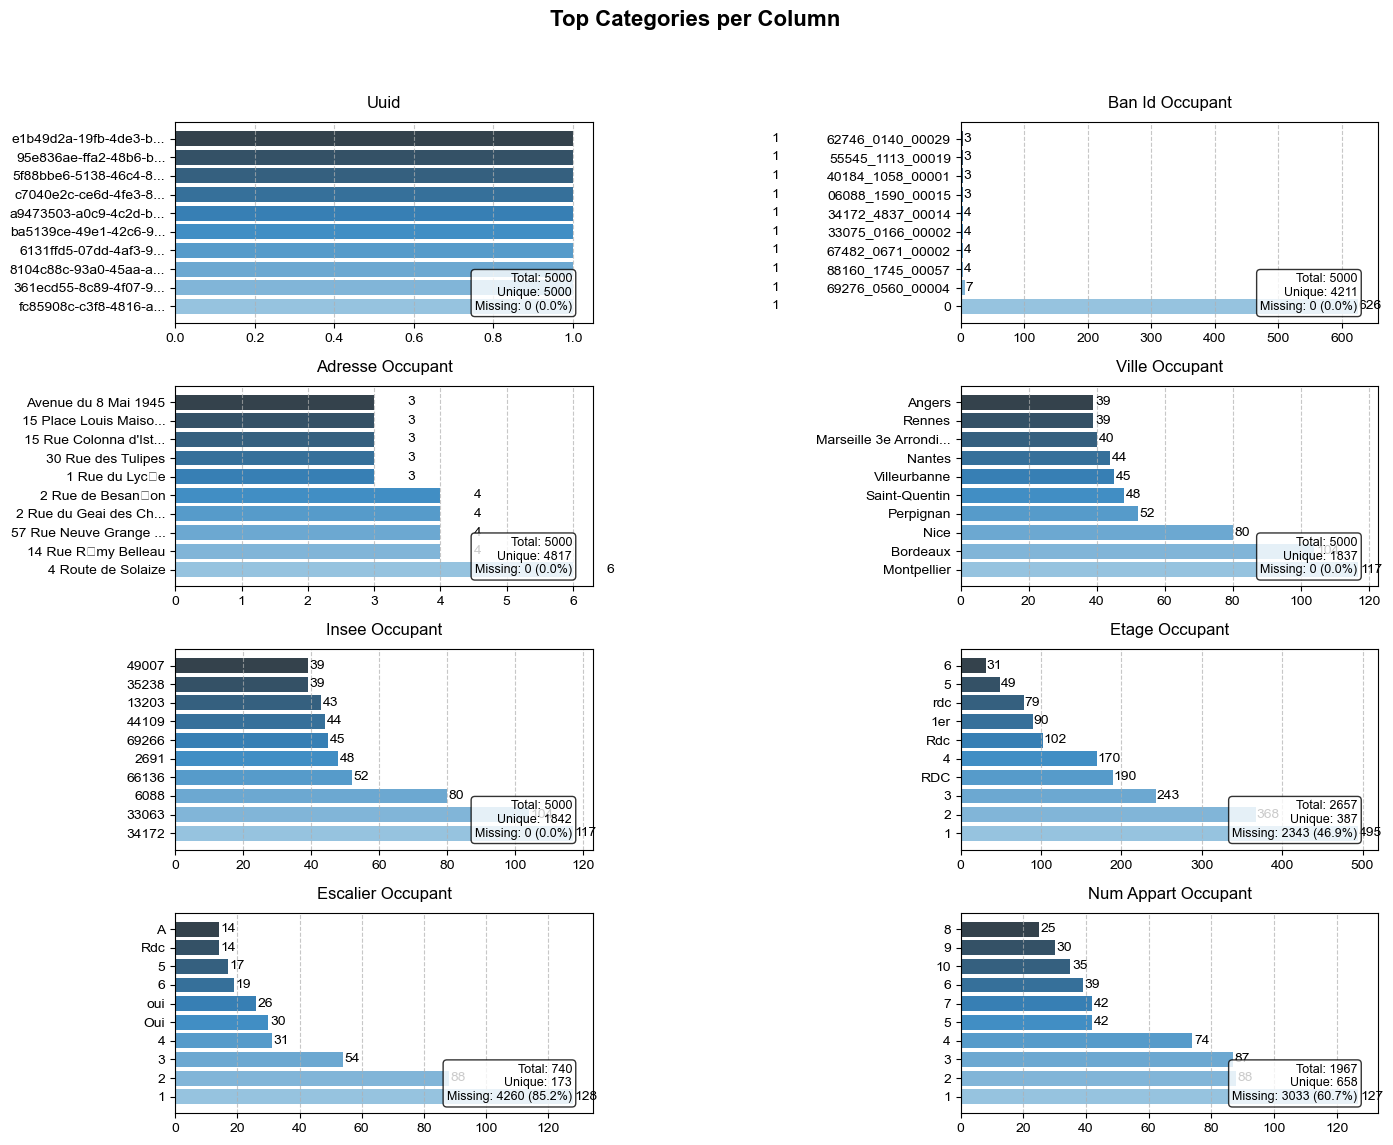

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import matplotlib
import warnings
from pandas.api.types import is_numeric_dtype
import re

# Set font preferences for better rendering
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['axes.titlesize'] = 14
matplotlib.rcParams['axes.labelsize'] = 12

def enhanced_describe(df, output_path=None, max_categorical_values=20, figsize=(14, 8)):
    """
    Generate an enhanced descriptive statistics summary for a DataFrame.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame to analyze.
    output_path : str, optional
        If provided, saves the visualization to this path.
    max_categorical_values : int, default=20
        Maximum number of unique values to display for categorical columns.
    figsize : tuple, default=(14, 8)
        Figure size (width, height) in inches.
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure object containing the visualization.
    """
    # Identify numeric columns
    numeric_cols = [col for col in df.columns if is_numeric_dtype(df[col]) or 
                    df[col].apply(lambda x: pd.to_numeric(x, errors='coerce')).notna().any()]
    
    # Convert columns to numeric where possible
    df_numeric = df[numeric_cols].copy()
    for col in numeric_cols:
        df_numeric[col] = pd.to_numeric(df_numeric[col], errors='coerce')
    
    # Get descriptive statistics
    desc_stats = df_numeric.describe().transpose()
    
    # Calculate additional statistics
    desc_stats['missing'] = df_numeric.isna().sum()
    desc_stats['missing_pct'] = (df_numeric.isna().sum() / len(df_numeric) * 100).round(2)
    desc_stats['zeros'] = (df_numeric == 0).sum()
    desc_stats['zeros_pct'] = ((df_numeric == 0).sum() / df_numeric.count() * 100).round(2)
    
    # Add range and skewness
    desc_stats['range'] = desc_stats['max'] - desc_stats['min']
    desc_stats['skewness'] = df_numeric.skew()
    
    # Format column names for better readability
    desc_stats.index = [format_column_name(col) for col in desc_stats.index]
    
    # Create the figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Hide the axes
    ax.axis('off')
    
    # Create a table
    table_data = []
    table_columns = ['Column', 'Count', 'Missing (%)', 'Min', 'Max', 'Mean', 'Median', 'Std Dev', 'Skew']
    
    for idx, row in desc_stats.iterrows():
        table_data.append([
            idx,
            f"{int(row['count']):,}",
            f"{row['missing_pct']:.1f}%",
            f"{row['min']:.2f}",
            f"{row['max']:.2f}",
            f"{row['mean']:.2f}",
            f"{row['50%']:.2f}",
            f"{row['std']:.2f}",
            f"{row['skewness']:.2f}"
        ])
    
    # Create the table
    the_table = ax.table(
        cellText=table_data,
        colLabels=table_columns,
        loc='center',
        cellLoc='center'
    )
    
    # Style the table
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(10)
    the_table.scale(1, 1.5)
    
    # Set header style
    for i, key in enumerate(table_columns):
        cell = the_table[(0, i)]
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor('#4472C4')
    
    # Alternate row colors
    for i in range(len(table_data)):
        for j in range(len(table_columns)):
            cell = the_table[(i+1, j)]
            if i % 2 == 0:
                cell.set_facecolor('#D9E1F2')
            else:
                cell.set_facecolor('#E9EDF4')
    
    # Highlight missing data
    for i in range(len(table_data)):
        missing_cell = the_table[(i+1, 2)]  # Missing percentage column
        missing_pct = float(table_data[i][2].strip('%'))
        if missing_pct > 50:
            missing_cell.set_facecolor('#FF9999')
        elif missing_pct > 20:
            missing_cell.set_facecolor('#FFCC99')
    
    # Title
    plt.suptitle('Enhanced Numeric Data Summary', fontsize=16, fontweight='bold', y=0.95)
    
    # Add note about non-numeric columns
    non_numeric_cols = [col for col in df.columns if col not in numeric_cols]
    if non_numeric_cols:
        plt.figtext(0.5, 0.01, 
                   f"Note: {len(non_numeric_cols)} non-numeric columns are not shown in this summary.",
                   ha="center", fontsize=10, style='italic')
    
    plt.tight_layout()
    
    # Save if path is provided
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
    
    return fig

def enhanced_categorical_describe(df, output_path=None, max_columns=8, max_categories=10, figsize=(14, 12)):
    """
    Generate an enhanced summary for categorical columns in a DataFrame.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame to analyze.
    output_path : str, optional
        If provided, saves the visualization to this path.
    max_columns : int, default=8
        Maximum number of categorical columns to display.
    max_categories : int, default=10
        Maximum number of categories to display per column.
    figsize : tuple, default=(14, 12)
        Figure size (width, height) in inches.
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure object containing the visualization.
    """
    # Identify categorical and object columns
    cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    
    # Limit the number of columns
    if len(cat_cols) > max_columns:
        cat_cols = cat_cols[:max_columns]
    
    if not cat_cols:
        # No categorical columns
        fig, ax = plt.subplots(figsize=(8, 2))
        ax.text(0.5, 0.5, "No categorical columns found in the dataset.", 
                ha='center', va='center', fontsize=14)
        ax.axis('off')
        if output_path:
            plt.savefig(output_path, dpi=300, bbox_inches='tight')
        return fig
    
    # Calculate the number of rows and columns for the subplot grid
    n_cols = min(2, len(cat_cols))
    n_rows = (len(cat_cols) + n_cols - 1) // n_cols
    
    # Create the figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, squeeze=False)
    
    # Flatten the axes array for easier indexing
    axes = axes.flatten()
    
    for i, col in enumerate(cat_cols):
        if i < len(axes):  # Ensure we don't exceed the number of axes
            # Get value counts
            value_counts = df[col].value_counts().head(max_categories)
            
            # Plot horizontal bar chart
            bars = axes[i].barh(range(len(value_counts)), value_counts, 
                               color=sns.color_palette("Blues_d", len(value_counts)))
            
            # Add value labels
            for j, (val, count) in enumerate(value_counts.items()):
                axes[i].text(count + 0.5, j, str(count), va='center')
            
            # Set labels
            axes[i].set_title(format_column_name(col), fontsize=12, pad=10)
            axes[i].set_yticks(range(len(value_counts)))
            
            # Format y-tick labels (truncate long values)
            y_labels = [str(val)[:20] + ('...' if len(str(val)) > 20 else '') for val in value_counts.index]
            axes[i].set_yticklabels(y_labels)
            
            # Add summary stats as text box
            total_values = df[col].count()
            unique_values = df[col].nunique()
            missing_values = df[col].isna().sum()
            missing_pct = missing_values / len(df) * 100
            
            stats_text = (f"Total: {total_values}\n"
                        f"Unique: {unique_values}\n"
                        f"Missing: {missing_values} ({missing_pct:.1f}%)")
            
            axes[i].text(0.95, 0.05, stats_text, transform=axes[i].transAxes,
                       fontsize=9, ha='right', va='bottom',
                       bbox={'boxstyle': 'round', 'facecolor': 'white', 'alpha': 0.8})
            
            # Add grid lines
            axes[i].grid(axis='x', linestyle='--', alpha=0.7)
    
    # Hide any unused axes
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.suptitle('Top Categories per Column', fontsize=16, fontweight='bold')
    
    if len(cat_cols) > max_columns:
        note = f"Note: Only showing {max_columns} of {len(df.select_dtypes(include=['object', 'category']).columns)} categorical columns."
        plt.figtext(0.5, 0.01, note, ha='center', fontsize=10, style='italic')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Save if path is provided
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
    
    return fig

def format_column_name(column_name):
    """Format a column name to make it more readable"""
    # Replace underscores with spaces
    formatted = str(column_name).replace('_', ' ')
    
    # Capitalize first letter of each word
    formatted = formatted.title()
    
    # Truncate if too long
    if len(formatted) > 30:
        formatted = formatted[:27] + '...'
    
    return formatted

# Function to create both visualizations
def create_enhanced_describe(df, output_dir='.'):
    """
    Create enhanced descriptive statistics visualizations
    
    Parameters:
    df (pandas.DataFrame): The dataset to analyze
    output_dir (str): Directory to save visualizations
    
    Returns:
    dict: Paths to all generated visualizations
    """
    import os
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Dictionary to store visualization paths
    viz_paths = {}
    
    # Numeric summary
    viz_paths['numeric_summary'] = os.path.join(output_dir, 'numeric_summary.png')
    enhanced_describe(df, viz_paths['numeric_summary'])
    
    # Categorical summary
    viz_paths['categorical_summary'] = os.path.join(output_dir, 'categorical_summary.png')
    enhanced_categorical_describe(df, viz_paths['categorical_summary'])
    
    return viz_paths


viz_paths = create_enhanced_describe(df, output_dir='data_summary')
print(f"Summary visualizations created at: {viz_paths}")
